In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [7]:
# Path to the data directory
data_dir = Path("D:\E\Python\captcha_images_v4")



# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 4

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])


Number of images found:  1051
Number of labels found:  1051
Number of unique characters:  12
Characters present:  {'ص', 'ث', 'ع', 'ق', 'ج', 'د', 'ح', 'ف', 'خ', 'ه', 'ض', 'غ'}


In [5]:
for i in range(1051):
    if len(labels[i])!=5 :
        print(labels[i])


In [8]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


In [31]:
print(x_valid)

['D:\\E\\Python\\captcha_images_v4\\ضقصغث.png'
 'D:\\E\\Python\\captcha_images_v4\\قهغقج.png'
 'D:\\E\\Python\\captcha_images_v4\\خحححه.png'
 'D:\\E\\Python\\captcha_images_v4\\صصضضف.png'
 'D:\\E\\Python\\captcha_images_v4\\هعخثق.png'
 'D:\\E\\Python\\captcha_images_v4\\عخخحح.png'
 'D:\\E\\Python\\captcha_images_v4\\عفدهص.png'
 'D:\\E\\Python\\captcha_images_v4\\ههخخه.png'
 'D:\\E\\Python\\captcha_images_v4\\فففدص.png'
 'D:\\E\\Python\\captcha_images_v4\\عضضهه.png'
 'D:\\E\\Python\\captcha_images_v4\\قفثهص.png'
 'D:\\E\\Python\\captcha_images_v4\\ججههث.png'
 'D:\\E\\Python\\captcha_images_v4\\قحعدث.png'
 'D:\\E\\Python\\captcha_images_v4\\ثفضحه.png'
 'D:\\E\\Python\\captcha_images_v4\\ضقصخث.png'
 'D:\\E\\Python\\captcha_images_v4\\ثهههث.png'
 'D:\\E\\Python\\captcha_images_v4\\ععخخث.png'
 'D:\\E\\Python\\captcha_images_v4\\غخخفف.png'
 'D:\\E\\Python\\captcha_images_v4\\قججحح.png'
 'D:\\E\\Python\\captcha_images_v4\\دحفثص.png'
 'D:\\E\\Python\\captcha_images_v4\\جهخقص.png'
 'D:\\E\\Pyth

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)


In [50]:
print(train_dataset)

<PrefetchDataset shapes: {image: (None, 200, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>


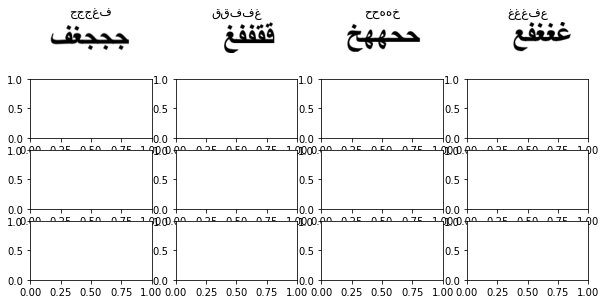

In [51]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()


In [57]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (4, 4),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        32,
        (4, 4),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    x = layers.Conv2D(
        64,
        (4, 4),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool3")(x)
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 8), (img_height // 8) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.3)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()


Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  544         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 32)  16416       pool1[0][0]                      
_______________________________________________________________________________________

In [58]:
epochs = 200
early_stopping_patience = 15
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/200
237/237 [==============================] - 5s 20ms/step - loss: 14.6280 - val_loss: 14.2731
Epoch 2/200
237/237 [==============================] - 3s 14ms/step - loss: 14.1512 - val_loss: 14.2835
Epoch 3/200
237/237 [==============================] - 3s 14ms/step - loss: 14.1304 - val_loss: 14.2948
Epoch 4/200
237/237 [==============================] - 3s 14ms/step - loss: 14.1163 - val_loss: 14.3427
Epoch 5/200
237/237 [==============================] - 3s 14ms/step - loss: 14.1059 - val_loss: 14.3099
Epoch 6/200
237/237 [==============================] - 3s 14ms/step - loss: 14.0981 - val_loss: 14.2737
Epoch 7/200
237/237 [==============================] - 3s 14ms/step - loss: 14.0927 - val_loss: 14.2570
Epoch 8/200
237/237 [==============================] - 3s 14ms/step - loss: 14.0823 - val_loss: 14.2387
Epoch 9/200
237/237 [==============================] - 3s 14ms/step - loss: 14.0344 - val_loss: 14.0336
Epoch 10/200
237/237 [==============================] - 3s 14ms/

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       544       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 32)       16416     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 50, 12, 64)        32832     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 25, 6, 64)        

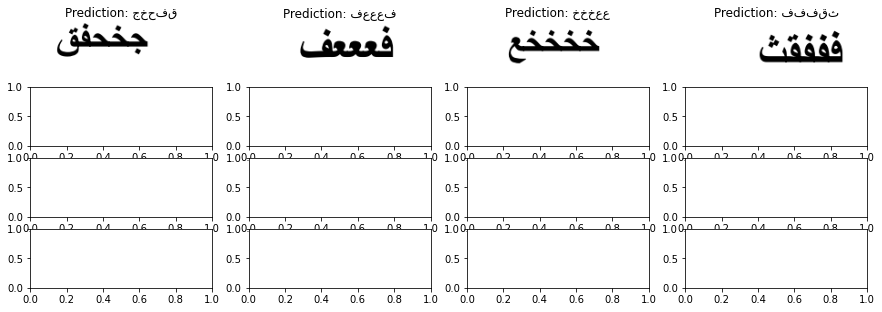

In [59]:
 #Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [60]:
preds = prediction_model.predict(validation_dataset)
pred_texts = decode_batch_predictions(preds)
print(pred_texts),print(y_valid)

['جخحفق', 'فعععف', 'خخخعع', 'فففقث', 'هقصحف', 'عغدقغ', 'ققغغث', 'غغققه', 'ثضصقف', 'عدددع', 'حخهعغ', 'دخخخد', 'عففصح', 'صصصدع', 'جععهه', 'دصخغع', 'صددجج', 'ضضثهغ', 'فقحثص', 'دحفثص', 'خهثقض', 'هجججه', 'حححصض', 'ععققف', 'دغغعع', 'صقثجغ', 'فقهثح', 'ففخخغ', 'غخهجد', 'عخضدف', 'ضقققض', 'عححخخ', 'ثثثصض', 'خخضضض', 'عصصثث', 'غصفضق', 'ضصصصث', 'غفدثه', 'غقهثغ', 'قحعدث', 'صدجعف', 'فهغخع', 'ججححع', 'هغغعع', 'ححععث', 'قصصخخ', 'ضصعثق', 'حدجثق', 'ععغغف', 'هغعثف', 'غفقصج', 'ضجججض', 'غخهدق', 'عضضصص', 'دفعغخ', 'قغفعه', 'هههغث', 'خهههخ', 'فغقحث', 'غعغعه', 'هعثغق', 'دجغخه', 'دهخجع', 'ججههق', 'حددجج', 'ضعفدخ', 'خخففح', 'فضضضف', 'فدعثف', 'خخغغح', 'ثدددث', 'ثثثدع', 'ضفثحف', 'فصصثث', 'فععغغ', 'خجججخ', 'ههففح', 'هعحقج', 'جعخقث', 'دضهغف', 'ققصصث', 'جحثغف', 'صصخخع', 'جثعفخ', 'هعدقع', 'خخففج', 'عددجج', 'دجججد', 'فقثعص', 'غعهخح', 'هججحح', 'ضضددق', 'فددجج', 'ضععغغ', 'هغغغه', 'حقققح', 'قفحخغ', 'عقصدح', 'ضصدجف', 'ضغغغض', 'ححععص', 'عجججع', 'ضع[UNK][UNK][UNK]', 'حثثقق', 'دحجعف', 'هحدفغ']
['جخحفق' 'فعععف' 'خخخخع' 'فففقث' 

(None, None)

In [ ]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Train the model
history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    epochs=50,
                    callbacks=[es])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 936 steps, validate for 104 steps
Epoch 1/50
936/936 [==============================] - 19s 20ms/step - loss: 16.6753 - val_loss: 16.5309
Epoch 2/50
936/936 [==============================] - 12s 13ms/step - loss: 16.3818 - val_loss: 16.5000
Epoch 3/50
936/936 [==============================] - 12s 13ms/step - loss: 16.2404 - val_loss: 16.1511
Epoch 4/50
936/936 [==============================] - 12s 13ms/step - loss: 16.1067 - val_loss: 16.1565
Epoch 5/50
936/936 [==============================] - 12s 13ms/step - loss: 16.0461 - val_loss: 16.1102
Epoch 6/50
936/936 [==============================] - 12s 13ms/step - loss: 16.0131 - val_loss: 16.1491
Epoch 7/50
936/936 [==============================] - 12s 13ms/step - loss: 15.9883 - val_loss: 16.1048
Epoch 8/50
936/936 [==============================] - 12s 13ms/step - loss: 15.9844 - val_loss: 16.1934
Epoch 9/50
936/936 [==============================] - 12s 13ms/step - loss